<a href="https://colab.research.google.com/github/DrZee24/ANN/blob/main/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import keras
import yfinance as yf
import keras.backend as K
!pip install py_vollib
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from py_vollib import black_scholes_merton as bsm
from progressbar import ProgressBar
from scipy.stats import gamma, beta, uniform
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split

In [1]:
def thisS(q):
    return gamma.ppf(q, a=100, scale=1)

def thisK(q):
    return uniform.ppf(q, 50, 200)

def thisR(q):
    return uniform.ppf(q, 0.01, 0.18)

def thisD(q):
    return uniform.ppf(q, 0.01, 0.18)

def thisSigma(q):
    return beta.ppf(q, a=2, b=5) + 0.001


In [5]:
def this_extremes_S(q):
    return uniform.ppf(q, 90, 110)
num_increment = 12
percentiles = pd.Series(np.linspace(0, 0.99, num_increment))
S = percentiles.apply(thisS).tolist()
K = percentiles.apply(thisK).tolist()
q = percentiles.apply(thisD).tolist()
t = np.array([.25, .5, .75, 1]).tolist()
r = percentiles.apply(thisR).tolist()
sigma = percentiles.apply(thisSigma).tolist()

param_grid = {'S': S, 'K': K, 'q': q, 't': t, 'r': r, 'sigma': sigma}
grid = ParameterGrid(param_grid)

data = []
for params in tqdm(grid, desc='Calcul des prix'):
    price = bsm.black_scholes_merton(flag='c', S=params['S'], K=params['K'],
                                     q=params['q'], t=params['t'], r=params['r'], sigma=params['sigma'])
    # Ajoutez le prix au dictionnaire des paramètres
    params['price'] = price
    # Ajoutez le dictionnaire à la liste
    data.append(params)
# Convertissez la liste de dictionnaires en DataFrame
fullDF = pd.DataFrame(data)
# Enregistrez le DataFrame dans un fichier CSV
fullDF.to_csv('dataFull.csv', index=False)
print(fullDF.head())
print(fullDF.tail())

Calcul des prix: 100%|██████████| 995328/995328 [00:14<00:00, 67069.94it/s]


      K    S     q     r    sigma     t  price
0  50.0  0.0  0.01  0.01  0.00100  0.25    0.0
1  50.0  0.0  0.01  0.01  0.00100  0.50    0.0
2  50.0  0.0  0.01  0.01  0.00100  0.75    0.0
3  50.0  0.0  0.01  0.01  0.00100  1.00    0.0
4  50.0  0.0  0.01  0.01  0.08819  0.25    0.0
            K           S       q       r     sigma     t     price
995323  248.0  124.722561  0.1882  0.1882  0.511316  1.00  3.015377
995324  248.0  124.722561  0.1882  0.1882  0.706686  0.25  0.575184
995325  248.0  124.722561  0.1882  0.1882  0.706686  0.50  3.027893
995326  248.0  124.722561  0.1882  0.1882  0.706686  0.75  5.940339
995327  248.0  124.722561  0.1882  0.1882  0.706686  1.00  8.688295


In [6]:
def baseline_model():
    # Créer le modèle de base
    i = Input(shape=(6,))  # Entrée avec 6 caractéristiques
    x = Dense(10, activation='relu')(i)
    y = Dense(10, activation='relu')(x)
    o = Dense(1)(y)  # Sortie avec 1 neurone
    Model(i, o)
    return Model(i, o)

Epoch 1/20
11198/11198 - 29s - loss: 12.8082 - val_loss: 3.5876 - 29s/epoch - 3ms/step
Epoch 2/20
11198/11198 - 22s - loss: 2.1758 - val_loss: 1.6055 - 22s/epoch - 2ms/step
Epoch 3/20
11198/11198 - 21s - loss: 1.5559 - val_loss: 1.4487 - 21s/epoch - 2ms/step
Epoch 4/20
11198/11198 - 20s - loss: 1.4118 - val_loss: 1.2961 - 20s/epoch - 2ms/step
Epoch 5/20
11198/11198 - 27s - loss: 1.3295 - val_loss: 1.3695 - 27s/epoch - 2ms/step
Epoch 6/20
11198/11198 - 23s - loss: 1.2786 - val_loss: 1.1681 - 23s/epoch - 2ms/step
Epoch 7/20
11198/11198 - 22s - loss: 1.2482 - val_loss: 1.2263 - 22s/epoch - 2ms/step
Epoch 8/20
11198/11198 - 21s - loss: 1.2309 - val_loss: 1.3725 - 21s/epoch - 2ms/step
Epoch 9/20
11198/11198 - 19s - loss: 1.2195 - val_loss: 1.1638 - 19s/epoch - 2ms/step
Epoch 10/20
11198/11198 - 21s - loss: 1.2083 - val_loss: 1.2406 - 21s/epoch - 2ms/step
Epoch 11/20
11198/11198 - 23s - loss: 1.2037 - val_loss: 1.1448 - 23s/epoch - 2ms/step
Epoch 12/20
11198/11198 - 21s - loss: 1.2023 - val_

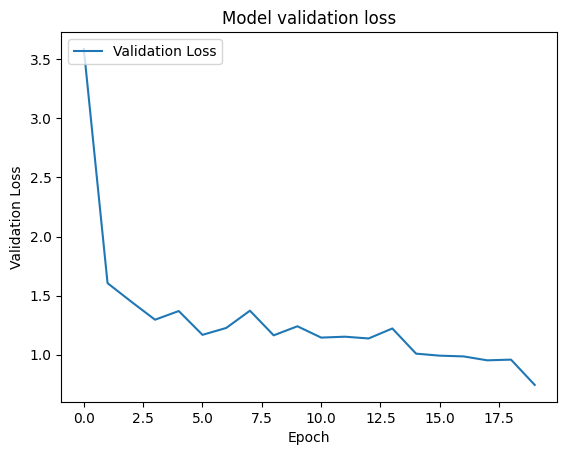

3111/3111 [==============================] - 4s 1ms/step - loss: 0.7366


0.7365686297416687

In [7]:
model_full = baseline_model()
model_full.compile(optimizer='adam', loss='mse')
X_full = fullDF[['S', 'K', 'q', 'r', 'sigma', 't']]
y_full = fullDF['price']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.1, random_state=7)
history_full = model_full.fit(X_train_full, y_train_full, batch_size=64, epochs=20, verbose=2, validation_split=0.2)
plt.plot(history_full.history['val_loss'])
plt.title('Model validation loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['Validation Loss'], loc='upper left')
plt.show()
model_full.evaluate(X_test_full, y_test_full)

3111/3111 [==============================] - 5s 1ms/step


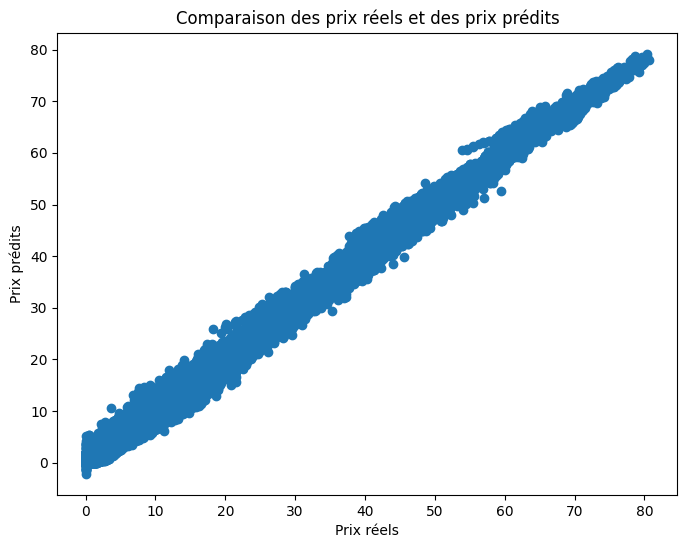

In [8]:

# Prédictions du modèle sur l'ensemble de test
predictions = model_full.predict(X_test_full)

# Tracer un diagramme de dispersion des prix prédits par rapport aux prix réels
plt.figure(figsize=(8, 6))
plt.scatter(y_test_full, predictions)
plt.xlabel('Prix réels')
plt.ylabel('Prix prédits')
plt.title('Comparaison des prix réels et des prix prédits')
plt.show()

les points sont alignés autour de la ligne diagonale (y = x), cela signifie que les prédictions du modèle correspondent étroitement aux valeurs réelles.